### Unix functions MITgcm

This file contains functions which are relevant for analysing data from the MITgcm model.

In [47]:
#IMPORTING
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import datetime

#### Reading and Loading Data

In [48]:
def readMITgcmData(var, bd='/data/oceans_output/shelf/kaight/mitgcm', members='all'):
    '''
    var: name of variable (string).
    bd: base directory, with PAS_PACE folders.
    members: members to read ('all' or list with boundaries (e.g. [0, 1] for member 1)).
    '''
    #Creating list with files to read.
    if members=='all':
        pdir=[os.path.join(bd, f) for f in os.listdir(bd) if ('PAS_PACE' in f) & ('hb' not in f)]
        numbers=20
    else:
        pdir=[os.path.join(bd, f) for f in os.listdir(bd) if ('PAS_PACE' in f) & ('hb' not in f)][members[0]:members[-1]]
        number=members[-1]-members[0]
        
    files=[os.path.join('output', f, 'MITgcm/output.nc') for f in os.listdir('/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01/output') if (f[0]==str(1)) | (f[0]==str(2))]
    
    #Reading the actual data.
    data=None

    for i, p in enumerate(pdir):
        print(p)
        fd=[os.path.join(p, f) for f in files]
        fd.sort()
        b=xr.open_dataset(fd[0])
        b=b[[var]]
        if var=='THETA':
            b=b.sel(Z=slice(-200, -700)).mean(dim='Z')

        for f in fd[1:]:
            a=xr.open_dataset(f)
            a=a[[var]]
            if var=='THETA':
                a=a.sel(Z=slice(-200, -700)).mean(dim='Z')
            b=xr.concat([b,a], dim='time')

        if i==0:
            data=b
        else:
            data=xr.concat([data,b], dim='ens')
        
    #Making sure that the dataset has the dimension 'ens'
    if number==1:
        data=data.expand_dims("ens")
            
    return data

In [49]:
def loadMITgcmData(filename='zonal_winds', members='all'):
    if members=='all':
        ens_list=np.arange(20)
    else:
        ens_list=np.arange(members[0], members[-1])
        
    for i in ens_list:
        print('Loading number:'+str(i))
        a=xr.open_dataset('./data/'+filename+'_ens'+str(i+1)+'.nc')
        if i==0:
            data=a
        else:
            data=xr.concat([data,a], dim='ens')   
    
    if len(ens_list)==1:
        data=data.expand_dims("ens")
    
    return data
    
    

In [50]:
def detrend_and_average_MITgcmData(data, var, window=24, method='mean', start='1920', end='2013', longwindow=12*25, min_periods=5*12):
    '''
    data: (xarray dataset)
    var: variable name (string)
    window: rolling mean window [months] (int)
    method: mean, linear or quadratic (string)
    start: start year (string)
    end: end year (string)
    longwindow: rolling mean window for detrening, 
                only during mean detrending[months] (int)
    min_periods: minimum number of datapoints for rolling mean window for detrending
                 only during mean detrending[months] (int)
    '''


    def detrend_dim(da, dim, deg=1):
        # detrend along a single dimension
        p = da.polyfit(dim=dim, deg=deg, skipna=True)
        #return p
        x=da[dim]
        fit = xr.polyval(x, p.polyfit_coefficients)
        return da - fit

    def detrend(da, dims, deg=1):
        # detrend along multiple dimensions
        # only valid for linear detrending (deg=1)
        da_detrended = da
        for dim in dims:
            da_detrended = detrend_dim(da_detrended, dim, deg=deg)
        return da_detrended
    
    data=data.sel(time=slice(start, end)).rolling(time=window, center=True).mean()
    
    if method=='linear':
        deg=1
        data=detrend(data[var], dims=['time'], deg=deg)
    elif method=='quadratic':
        deg=2
        data=detrend(data[var], dims=['time'], deg=deg)
    elif method=='mean':
        long_mean=data.rolling(time=longwindow, center=True, min_periods=min_periods).mean()
        data=data-long_mean
        data=data[var]
    
    return data
    

In [51]:
def readMITgcmTimeSeries(var, bd='/data/oceans_output/shelf/kaight/mitgcm', members='all', tf='timeseries_final.nc'):
    '''
    var: name of variable (string).
    bd: base directory, with PAS_PACE folders.
    members: members to read ('all' or list with boundaries (e.g. [0, 1] for member 1)).
    tf: timeseries file name (string)
    '''
    
    if members=='all':
        pdir=[os.path.join(bd, f) for f in os.listdir(bd) if ('PAS_PACE' in f) & ('hb' not in f)]
        number=20
    else:
        pdir=[os.path.join(bd, f) for f in os.listdir(bd) if ('PAS_PACE' in f) & ('hb' not in f)][members[0]:members[-1]]
        number=members[-1]-members[0]
        
    tsfiles=[os.path.join(p, 'output', tf) for p in pdir]
    
    ts=None

    #print(p)
    fd=tsfiles
    fd.sort()
    b=xr.open_dataset(fd[0])
    b=b[[var]]

    for i, f in enumerate(fd[1:]):
        a=xr.open_dataset(f)
        a=a[[var]]
        b=xr.concat([b,a], dim='ens')
    
    ts=b
    if number==1:
        ts=ts.expand_dims("ens")
    
    return ts

### Creating a correlation map
This code is made for the creation of correlation maps between one spatial variable and one time series

In [52]:
def findOptimalLag(ts, tm):
    lags=np.arange(-24, 24)
    r=np.zeros(len(lags))

    for z, lag in enumerate(lags):
        ts_temp=ts.shift(time=lag)
        tma=tm.stack(ens_time=['ens', 'time'])
        tsa=ts_temp.stack(ens_time=['ens', 'time'])
        a=xr.corr(tma, tsa, dim='ens_time')
        r[z]=a

    plt.plot(lags, r)
    maxind=np.argmax(r)
    final_lag=lags[maxind]
    
    return final_lag

In [53]:
def computeCorrelation(data, ts, final_lag):
    #Correlation
    ts_temp=ts.shift(time=final_lag)
    da=data.stack(ens_time=['ens', 'time'])
    tsa=ts_temp.stack(ens_time=['ens', 'time'])

    #This is a bit tricky.... Drop the NaN values...
    da=da.drop_sel(ens_time=tsa[np.isnan(tsa)].ens_time)
    tsa=tsa.dropna(dim='ens_time')
    
    tsa=tsa.drop_sel(ens_time=da[0,0,:][np.isnan(da[0,0,:])].ens_time)
    da=da.dropna(dim='ens_time')
    
    cors=np.zeros((len(da.YC), len(da.XC)))
    p=np.zeros((len(da.YC), len(da.XC)))

    for i in range(len(da.YC)):
        for j in range(len(da.XC)):
            cors[i,j], p[i,j]=stats.pearsonr(da.values[i,j,:],tsa)
            
    print('Finished!')
    
    return cors, p

In [54]:
def makeCorrMap(cors, p=None, final_lag=-9, title='Correlation Map', gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/', region='amundsen_sea', ymax=None, show_p=False, show_box=True):
    #From my code to Kaitlin's code
    from mitgcm_python_master.plot_latlon import latlon_plot
    from mitgcm_python_master.grid import ERA5Grid, PACEGrid, Grid, dA_from_latlon, pierre_obs_grid
    from mitgcm_python_master.utils import real_dir, daily_to_monthly, fix_lon_range, split_longitude, mask_land_ice, moving_average, index_year_start, index_year_end, index_period, mask_2d_to_3d, days_per_month, add_time_dim, z_to_xyz, select_bottom, convert_ismr, mask_except_ice, xy_to_xyz, apply_mask, var_min_max, mask_3d, average_12_months, depth_of_isoline, mask_land, axis_edges
    from mitgcm_python_master.plot_utils.latlon import shade_mask, overlay_vectors

    grid = Grid(gp)
    mask = grid.get_region_mask(region)
    mask=mask.astype(bool)
    
    #Prepare everything for the map!
    r_data = np.zeros([grid.ny, grid.nx])

    r_data[mask] = cors[mask]

    r_data = mask_land_ice(r_data, grid)
    print(('Mean r over all points and ensemble members = '+str(np.nanmean(r_data))))
    r_data[np.isnan(r_data)]=0

    vmin=np.min(r_data[mask])
    vmax=np.max(r_data[mask])      

    levels=np.arange(0, 1, 0.1)
    
    #Plot the Map
    fig, ax=plt.subplots(figsize=(14,5))

    latlon_plot(r_data, grid, ctype='plusminus', ymax=ymax, vmin=None, vmax=None, title=title+' at optimum lag of '+str(final_lag)+' months', titlesize=14, figsize=(14,5), ax=ax)
    r=ax.contour(grid.lon_2d, grid.lat_2d, r_data, levels=levels, colors=['yellow'])
    plt.clabel(r, levels)

    bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
    plt.clabel(bath, [-1000])

    if show_p==True:
        p_data = np.zeros([grid.ny, grid.nx])
        p_data[mask] = p[mask]
        p_data = mask_land_ice(p_data, grid)
        a=5
        ax.scatter(grid.lon_2d[::a, ::a][(p_data[::a, ::a]<=0.05) & (p_data[::a, ::a].mask==False)], grid.lat_2d[::a, ::a][(p_data[::a, ::a]<=0.05) & (p_data[::a, ::a].mask==False)], c='k', s=.02)

    if show_box==True:
        x=[-115, -102, -102, -115, -115]
        y=[-71.8, -71.8, -70.2,  -70.2, -71.8] 
        ax.plot(x, y, c='g', marker='o')
        
    return fig

In [55]:
def createCorrelationMap(data, ts, tm, title='Correlation map', 
                         filename='correlation_map', method='mean', 
                         window=24, long=25*12, members='all'):
    
    from mitgcm_python_master.plot_utils.windows import finished_plot, set_panels
    
    #Completing the title
    title=title+'\n (both {} month moving average,'.format(str(window))
    if method=='linear':
        title+=' linearly detrended)'
    elif method=='quadratic':
        title+=' quadratically detrended)'
    elif method=='mean':
        title+='  detrended with {} month rolling mean)'.format(str(long))
    if members=='all':
        title+=' (full ensemble)'
    else:
        title+=' ({} members)'.format(str(members[-1]-members[0]))
    
    final_lag=findOptimalLag(ts, tm)
    cors,p=computeCorrelation(data, ts, final_lag)
    fig=makeCorrMap(cors=cors, p=p, final_lag=final_lag, title=title)
    
    
    from datetime import date
    today = date.today()
    today=today.strftime("%Y%m%d")
    
    finished_plot(fig, fig_name='./figures/'+filename+today+'.png', dpi=300)
    
    return

### Creating Composites
Below here, the code is specifically aimed at creating composites maps.

In [56]:
def read_all_data(full, total, units, longnames, kind):
    file_paths=[os.path.join(full, file) for file in os.listdir(full) if kind in file]
    
    
    names=['ens'+str(file[-5:-3]) for file in file_paths]
    
    print(file_paths)
    varlist=list(xr.open_dataset(file_paths[1]).variables)
    
    for var in varlist:
        total[var]=pd.DataFrame()    
    for i, file in enumerate(file_paths):
        data=xr.open_dataset(file)
        
        timeind=netcdf_time(file, monthly=False)
        
        for var in varlist:
            total[var][names[i]]=pd.Series(data[var], index=timeind)
            if (i==0) & (var!='time'):
                units[var]=data[var].units
                longnames[var]=data[var].long_name
            
    return total, units, longnames

def netcdf_time (file_path, var_name='time', t_start=None, t_end=None, return_date=True, monthly=True, return_units=False):

    import netCDF4 as nc

    # Open the file and get the length of the record
    id = nc.Dataset(file_path, 'r')
    time_id = id.variables[var_name]
    units = time_id.units
    try:
        calendar = time_id.calendar
    except(AttributeError):
        calendar = 'standard'
    num_time = time_id.size

    # Choose range of time values to consider
    # If t_start and/or t_end are already set, use those bounds
    # Otherwise, start at the first time_index and/or end at the last time_index in the file
    if t_start is None:
        t_start = 0
    if t_end is None:
        t_end = num_time

    # Read the variable
    if return_date:
        # Return as handy Date objects
        time = nc.num2date(time_id[t_start:t_end], units=units, calendar=calendar)
    else:
        # Return just as scalar values
        time = time_id[t_start:t_end]
    id.close()

    if return_date:
        # Want to convert to a datetime object
        if monthly:
            # Back up to previous month
            for t in range(time.size):
                month = time[t].month-1
                year = time[t].year
                if month < 1:
                    month += 12
                    year -= 1
                time[t] = datetime.datetime(year, month, 1)
        else:
            for t in range(time.size):
                time[t] = datetime.datetime(time[t].year, time[t].month, time[t].day)             

    if return_units:
        return time, units, calendar
    else:
        return time

In [57]:
def show_selected_periods(sel, cind, indnms=['ONI'], windows=[1], xlim=[1920,2020], col=None, title=''):
    #plt.figure(figsize=(20,10))
    plt.title(title)
    for i, nm in enumerate(indnms):
        #plt.subplot(np.ceil(len(indnms)/2), 2, i+1)
        if col==None:
            cind[nm].rolling(windows[i], center=True).mean().plot()
        else:
            cind[nm][col].rolling(windows[i], center=True).mean().plot()
        try:
            sel=sel.to_series()
        except:
            sel=sel
        for j in range(len(sel)):
            if (sel.iloc[j]==True) & (sel.iloc[j-1]==False):
                c=0
                while sel.iloc[j+c]==True:
                    c+=1       
                plt.axvspan(sel.index[j], sel.index[j+c-1], color='red', alpha=0.3)
        plt.hlines(0, pd.to_datetime('1910'), pd.to_datetime('2020'), colors='k', linestyles='dashed')
        plt.grid()
        plt.xlim([pd.to_datetime(str(k)) for k in xlim])
        #plt.ylabel(nm)
        #plt.title(nm+'; {} month rolling mean (centered)'.format(windows[i]))
    return

In [72]:
#STEP 1: FINDING MELT EVENTS

def findHighMeltEvents(wvar='dotson_to_cosgrove_massloss', window=24,
                       pct=90, larger_than=True,
                       method='mean', longwindow=12*25, min_periods=5*12,
                       start='1920', end='2013',
                       full='/data/hpcdata/users/grejan/mitgcm/data'):
    
    total={}
    units={}
    longnames={}
    total, units, longnames=read_all_data(full, total, units, longnames, kind='isotherm')
    total, units, longnames=read_all_data(full, total, units, longnames, kind='final')
    
    
    plt.figure(figsize=(20,10))

    long=total[wvar][start:end].rolling(longwindow, min_periods=min_periods, center=True).mean()

    threshold=np.nanpercentile(total[wvar][start:end].rolling(window, center=True).mean()-long, pct)
    windows=[window]

    selected=pd.DataFrame()

    a=[pd.to_datetime(str(j)) for j in np.arange(1920, 2011, 20)]
    b=[str(j) for j in np.arange(1920, 2011, 20)]
    for i in range(len(total[wvar].columns)):    
        ax=plt.subplot(5,4,i+1)
        col=total[wvar].columns[i]
        if larger_than==True:
            sel=(total[wvar][col][start:end].rolling(window, center=True).mean()-total[wvar][col][start:end].rolling(longwindow, min_periods=min_periods, center=True).mean())>threshold
        elif larger_than==False:
            sel=(total[wvar][col][start:end].rolling(window, center=True).mean()-total[wvar][col][start:end].rolling(longwindow, min_periods=min_periods, center=True).mean())<threshold

        selected[col]=sel

        show_selected_periods(sel, total, indnms=[wvar], windows=windows, xlim=[1920,2020], col=col, title='')

        plt.ylabel(units[wvar])    
        plt.ylim([0, 250])
        plt.xticks(a,b)
        ax.grid(True)


    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    plt.suptitle(longnames[wvar]+';\n {} month rolling mean (centered)'.format(windows[0])+'\n Threshold: {} percentile of: '.format(pct)+longnames[wvar])
    
    return selected, units

In [73]:
def makeCompositeAnimation(data, months=[-25,5], show_box=True, title='Composite map',
                           filename='map',
                           vmin_pct=0.3, vmax_pct=0.7,
                           gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/',
                           unit='[m/s]',
                           region='amundsen_sea', wvar='dotson_to_cosgrove_massloss', pct=90, larger_than=True):
    
    #From my code to Kaitlin's code
    from mitgcm_python_master.plot_latlon import latlon_plot
    from mitgcm_python_master.grid import ERA5Grid, PACEGrid, Grid, dA_from_latlon, pierre_obs_grid
    from mitgcm_python_master.utils import real_dir, daily_to_monthly, fix_lon_range, split_longitude, mask_land_ice, moving_average, index_year_start, index_year_end, index_period, mask_2d_to_3d, days_per_month, add_time_dim, z_to_xyz, select_bottom, convert_ismr, mask_except_ice, xy_to_xyz, apply_mask, var_min_max, mask_3d, average_12_months, depth_of_isoline, mask_land, axis_edges
    from mitgcm_python_master.plot_utils.latlon import shade_mask, overlay_vectors
    from mitgcm_python_master.plot_utils.windows import finished_plot, set_panels
    from matplotlib.animation import FuncAnimation
    import matplotlib.animation as animation
    
    fig, ax=plt.subplots(figsize=(14,5))
    moi=months[0]
    
    cors=data.sel(time=moi).mean(dim='time')
    try:
        cors=cors.to_array().to_numpy()[:,:]
    except:
        cors=cors.to_numpy()[:,:]
    
    grid = Grid(gp)
    region=region
    mask = grid.get_region_mask(region)
    mask=mask.astype(bool)

    vmax=data.quantile(vmax_pct).to_numpy()
    vmin=data.quantile(vmin_pct).to_numpy()

    #Prepare everything for the map!
    r_data = np.zeros([grid.ny, grid.nx])
    r_data[mask] = cors[mask]
    r_data = mask_land_ice(r_data, grid)
    r_data[np.isnan(r_data)]=0
    if larger_than==True:
        title_new=title+'\n (time since time of detection: {} months, threshold: above {} percentile of {})'.format(str(moi), str(pct), wvar)
    else:
        title_new=title+'\n (time since time of detection: {} months, threshold: below {} percentile of {})'.format(str(moi), str(pct), wvar)

    #Plot the Map
    img=latlon_plot(r_data, grid, ctype='plusminus', vmin=vmin, vmax=vmax, title=title_new, titlesize=14, figsize=(14,5), ax=ax, make_cbar=False)
    cbar = plt.colorbar(img)

    cbar.ax.set_ylabel(unit, rotation=270)

    bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
    plt.clabel(bath, [-1000])

    show_box=True
    if show_box==True:
        x=[-115, -102, -102, -115, -115]
        y=[-71.8, -71.8, -70.2,  -70.2, -71.8] 
        ax.plot(x, y, c='g', marker='o')


    # animation function
    def animate(i):
        print(i)
        moi=i-25


        cors=data.sel(time=moi).mean(dim='time')
        try:
            cors=cors.to_array().to_numpy()[:,:]
        except:
            cors=cors.to_numpy()[:,:]

        #Prepare everything for the map!
        r_data = np.zeros([grid.ny, grid.nx])
        r_data[mask] = cors[mask]
        r_data = mask_land_ice(r_data, grid)
        r_data[np.isnan(r_data)]=0

        if larger_than==True:
            title_new=title+'\n (time since time of detection: {} months, threshold: above {} percentile of {})'.format(str(moi), str(pct), wvar)
        else:
            title_new=title+'\n (time since time of detection: {} months, threshold: below {} percentile of {})'.format(str(moi), str(pct), wvar)

        #Plot the Map
        img=latlon_plot(r_data, grid, ctype='plusminus', vmin=vmin, vmax=vmax, title=title_new, titlesize=14, figsize=(14,5), ax=ax, make_cbar=False)

        bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
        plt.clabel(bath, [-1000])

        show_box=True
        if show_box==True:
            x=[-115, -102, -102, -115, -115]
            y=[-71.8, -71.8, -70.2,  -70.2, -71.8] 
            ax.plot(x, y, c='g', marker='o')

        return 

    
    from datetime import date
    today = date.today()
    today=today.strftime("%Y%m%d")
    
    anim = animation.FuncAnimation(fig, animate, frames=months[-1]-months[0], repeat=False, interval=1000)
    writergif = animation.PillowWriter(fps=2)
    anim.save('./figures/animation_composite_'+filename+'_'+today+'.gif', writer=writergif)
    return

In [74]:
def makeCompositeMap(data, months=[-25,3], show_box=True, title='Composite map',
                     filename='map',
                     vmin=None, vmax=None, 
                     gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/',
                     unit='[m/s]',
                     region='amundsen_sea', wvar='dotson_to_cosgrove_massloss', pct=90, larger_than=True):
    
    #From my code to Kaitlin's code
    from mitgcm_python_master.plot_latlon import latlon_plot
    from mitgcm_python_master.grid import ERA5Grid, PACEGrid, Grid, dA_from_latlon, pierre_obs_grid
    from mitgcm_python_master.utils import real_dir, daily_to_monthly, fix_lon_range, split_longitude, mask_land_ice, moving_average, index_year_start, index_year_end, index_period, mask_2d_to_3d, days_per_month, add_time_dim, z_to_xyz, select_bottom, convert_ismr, mask_except_ice, xy_to_xyz, apply_mask, var_min_max, mask_3d, average_12_months, depth_of_isoline, mask_land, axis_edges
    from mitgcm_python_master.plot_utils.latlon import shade_mask, overlay_vectors
    from mitgcm_python_master.plot_utils.windows import finished_plot, set_panels

    for moi in np.arange(months[0],months[-1]):
        #VISUALISATION:
        cors=data.sel(time=moi).mean(dim='time')
        try:
            cors=cors.to_array().to_numpy()[:,:]
        except:
            cors=cors.to_numpy()[:,:]
        
        grid = Grid(gp)
        region=region
        mask = grid.get_region_mask(region)
        mask=mask.astype(bool)

        #Prepare everything for the map!
        r_data = np.zeros([grid.ny, grid.nx])
        r_data[mask] = cors[mask]
        r_data = mask_land_ice(r_data, grid)
        r_data[np.isnan(r_data)]=0

        if larger_than==True:
            title_new=title+'\n (time since time of detection: {} months, threshold: above {} percentile of {})'.format(str(moi), str(pct), wvar)
        else:
            title_new=title+'\n (time since time of detection: {} months, threshold: below {} percentile of {})'.format(str(moi), str(pct), wvar)

        #Plot the Map
        fig, ax=plt.subplots(figsize=(14,5))
        img=latlon_plot(r_data, grid, ctype='plusminus', vmin=vmin, vmax=vmax, title=title_new, titlesize=14, figsize=(14,5), ax=ax, make_cbar=False)
        cbar = plt.colorbar(img)

        cbar.ax.set_ylabel(unit, rotation=270)


        bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
        plt.clabel(bath, [-1000])

        if show_box==True:
            x=[-115, -102, -102, -115, -115]
            y=[-71.8, -71.8, -70.2,  -70.2, -71.8] 
            ax.plot(x, y, c='g', marker='o')

    
        from datetime import date
        today = date.today()
        today=today.strftime("%Y%m%d")
    
        finished_plot(fig, fig_name='./figures/composite_'+filename+'_'+str(moi)+'_'+today+'.png', dpi=300)

In [75]:
def createCompositeMap(data, title='Composite map', 
                       filename='map', window=24, method='mean', 
                       longwindow=12*25, 
                       unit='[m/s]',
                       members='all', larger_than=True, pct=90): 
    
    def month_diff(a, b):
        return round(((a - b)/np.timedelta64(1, 'M')))
    
    #First, we need to identify the moments of interest.
    selected, units=findHighMeltEvents(wvar='dotson_to_cosgrove_massloss', window=24,
                       pct=pct, larger_than=larger_than,
                       method='mean', longwindow=12*25, min_periods=5*12,
                       start='1920', end='2013',
                       full='/data/hpcdata/users/grejan/mitgcm/data')
    
    #Find the start date per ensemble member.
    start_list=pd.DataFrame()
    for ens in selected.columns:
        start=np.array([False,]*len(selected[ens]))
        for i in range(len(selected[ens])):
            if (selected[ens].iloc[i]==True) & (selected[ens].iloc[i-1]==False):
                start[i]=True
        start_list[ens]=pd.Series(start, index=selected[ens].index)
    
    
    #Load the correct data and give it a relative time name.
    columns=start_list.columns
    columns=columns.sort_values()
    
    for i, ens in enumerate(columns):
        print('Ens is: '+str(ens))
        years=start_list[ens][start_list[ens]==True].index.year.values
        for year in years:
            a=data.sel(ens=0).sel(time=slice(str(year-2), str(year)))
            if year==years[0]:
                b=a
            else:
                b=xr.concat([b,a], dim='time')
                
        times=b.indexes['time'].to_datetimeindex()

        reltime=np.ones(len(times))*99 #relative time to the the starting month [months]

        kappa=0
        for iota, t in enumerate(times):
            if start_list[ens][start_list[ens]==True].index[kappa].year>=t.year:
                reltime[iota]=month_diff(t, start_list[ens][start_list[ens]==True].index[kappa])
            else:
                kappa+=1
                reltime[iota]=month_diff(t, start_list[ens][start_list[ens]==True].index[kappa])

        b['time']=reltime        
                
        
        if i==0:
            data_new=b
        else:
            data_new=xr.concat([data_new,b], dim='time')
            
            
    #Completing the title
    title=title+'\n (both {} month moving average,'.format(str(window))
    if method=='linear':
        title+=' linearly detrended)'
    elif method=='quadratic':
        title+=' quadratically detrended)'
    elif method=='mean':
        title+='  detrended with {} month rolling mean)'.format(str(longwindow))
    if members=='all':
        title+=' (full ensemble)'
    else:
        title+=' ({} members)'.format(str(members[-1]-members[0]))
    
    print('Starting with plotting')
    #When data is read, let's start with the plotting!
    makeCompositeMap(data=data_new, months=[-25,3], title=title, filename=filename, unit=unit, 
                     pct=pct, larger_than=larger_than)
    makeCompositeAnimation(data=data_new, months=[-25,3], title=title, filename=filename, unit=unit, 
                           pct=pct, larger_than=larger_than)
    
    print('Finished!')
    
    return
    
    
    

### Finally, run the full model!

In [62]:
#Defining the input. 
#members='all'
#var='EXFuwind'
#tmvar='amundsen_shelf_break_uwind_avg'

members=[0,2]
var='oceTAUX'
dataX=readMITgcmData(var=var, members=members)

dataX=dataX.rename({'oceTAUX':'curlTAU', 'XG':'XC'})
dataX=dataX.differentiate('YC')

var='oceTAUY'
data=readMITgcmData(var=var, members=members)
data=data.rename({'oceTAUY':'curlTAU', 'YG':'YC'})
data=data.differentiate('XC')

data=xr.Dataset(data_vars=dict(curlTAU=(['ens', 'time', 'YC', 'XC'], data['curlTAU'].values-dataX['curlTAU'].values)), coords=dict(ens=dataX.ens, time=dataX.time, XC=dataX.XC, YC=dataX.YC))

var='curlTAU'

#Reading the data.
#save=True
#data=readMITgcmData(var=var, members=members)

#if save==True:
#    for i in range(len(data.ens)):
#        data.sel(ens=i).to_netcdf('./data/zonal_winds_ens'+str(i+1)+'.nc')


#Loading the data.
#data=loadMITgcmData(filename='zonal_winds', members=members)


/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE02
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE02


In [ ]:
window=24
data_dt=detrend_and_average_MITgcmData(data, var, window=window)


['/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE20.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE19.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE18.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE17.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE16.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE15.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE14.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE13.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE12.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE11.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE10.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE09.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE08.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PAC

/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens02


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens03


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens04


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens05


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens06


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens07


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens08


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens09


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens10


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens11


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens12


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens13


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens14


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens15


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens16


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens17


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens18


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens19


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Ens is: ens20


/tmp/ipykernel_44569/1832800306.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  times=b.indexes['time'].to_datetimeindex()


Starting with plotting


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-25_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-24_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-23_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-22_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-21_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-20_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-19_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-18_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-17_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-16_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-15_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-14_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-13_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-12_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-11_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-10_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-9_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-8_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-7_20220304.png


/tmp/ipykernel_44569/589993972.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax=plt.subplots(figsize=(14,5))
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-6_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-5_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-4_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-3_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-2_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_-1_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_0_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_1_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./figures/composite_24monthmean_curlTAU_2_20220304.png


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


0


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


0


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


1


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


2


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


3


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


4


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


5


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


6


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


7


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


8


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


9


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


10


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


11


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


12


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


13


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


14


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


15


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


16


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


17


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


18


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


19


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


20


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


21


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


22


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


23


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


24


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


25


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


26


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


27


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Finished!


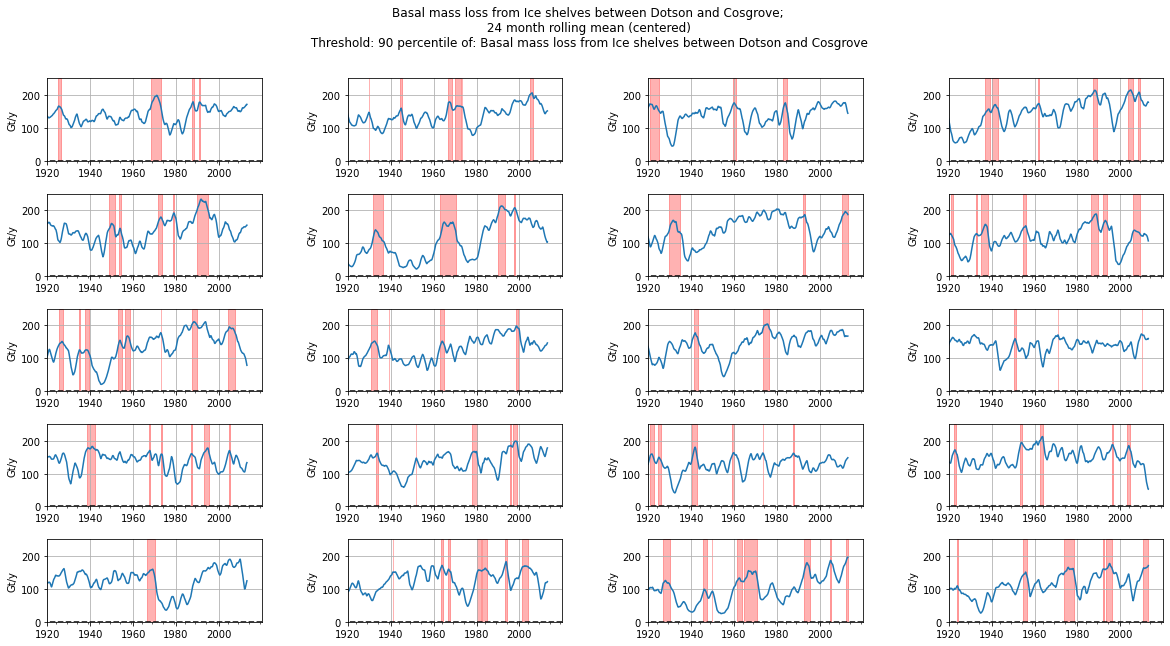

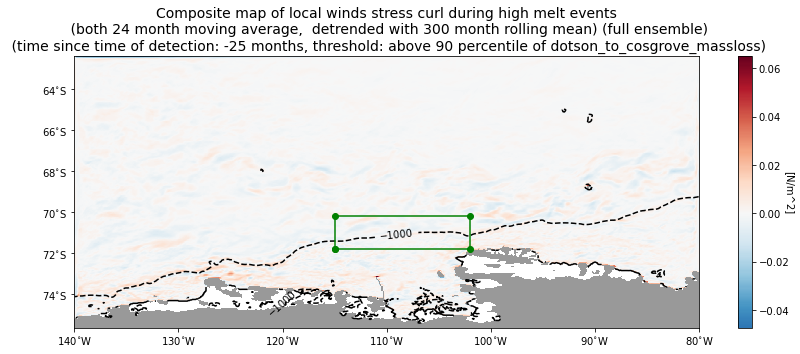

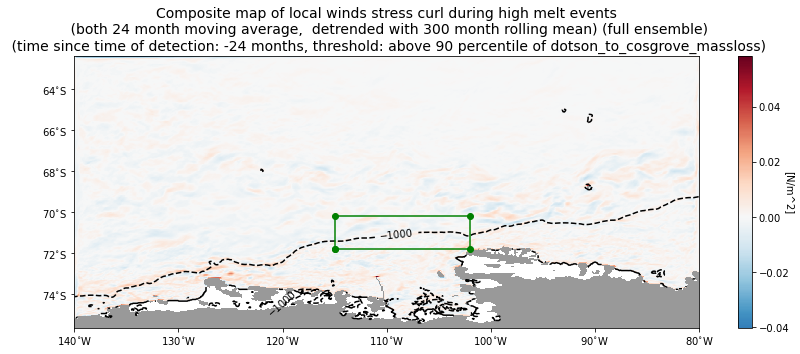

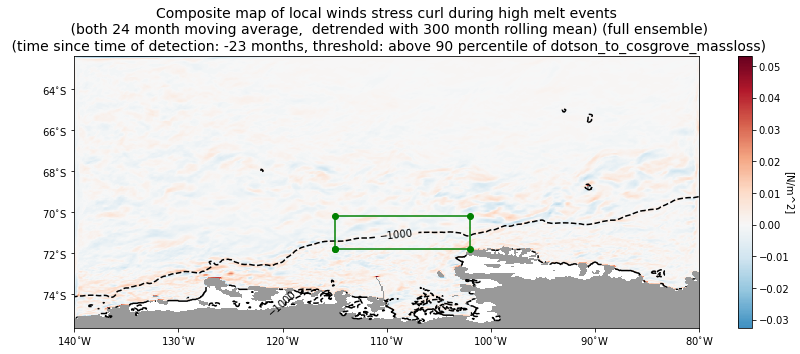

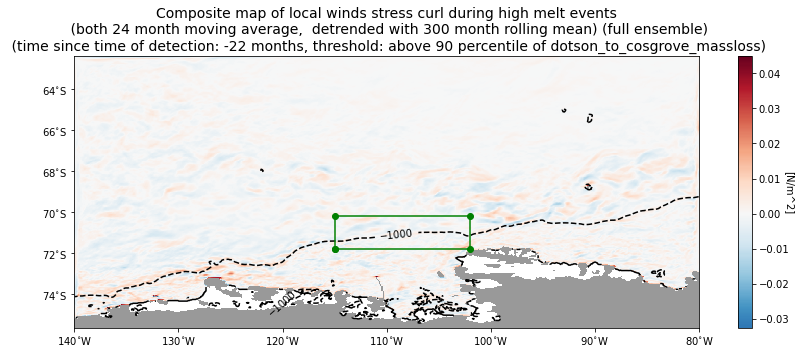

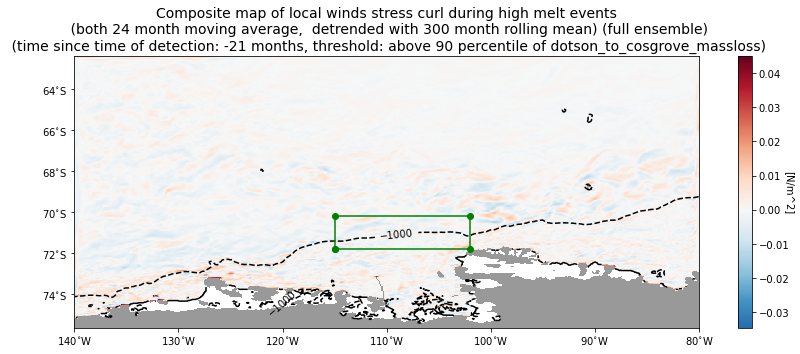

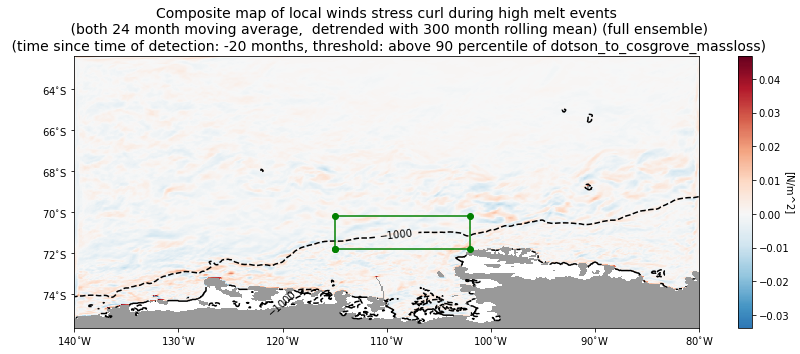

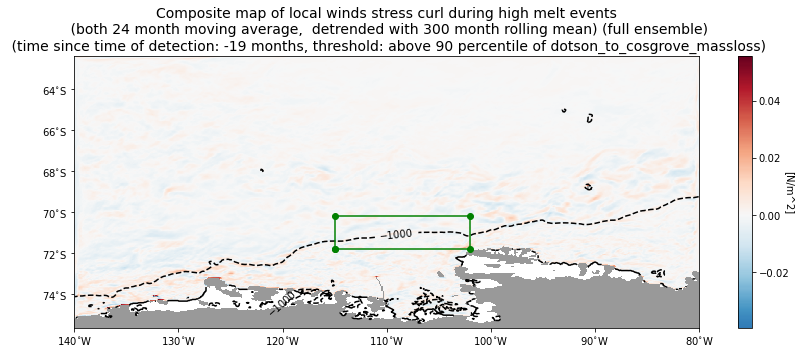

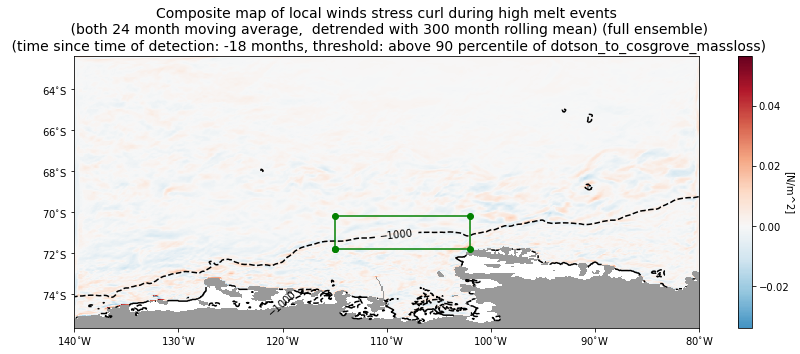

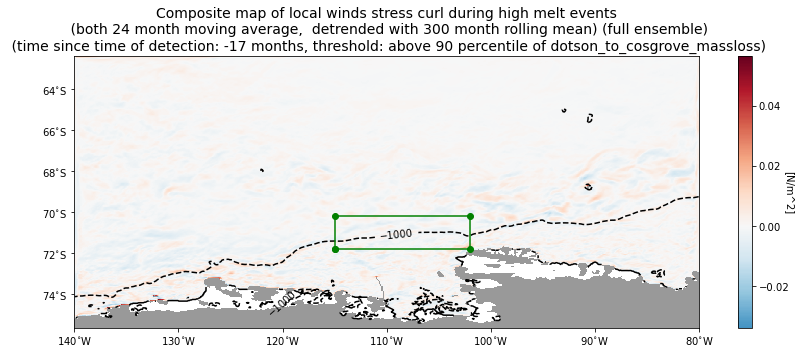

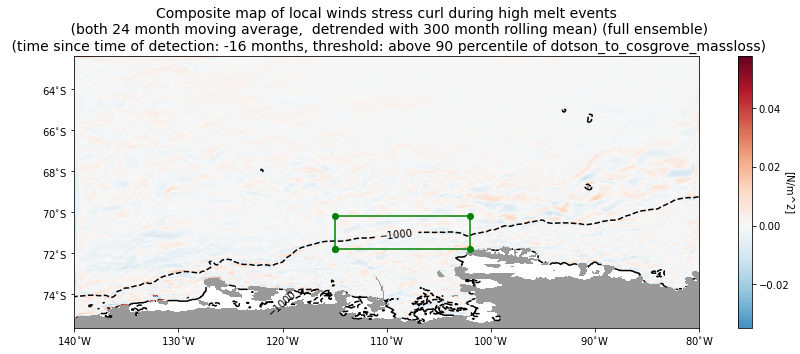

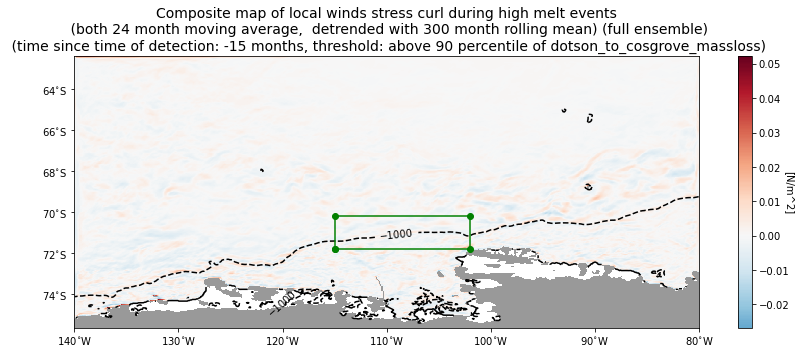

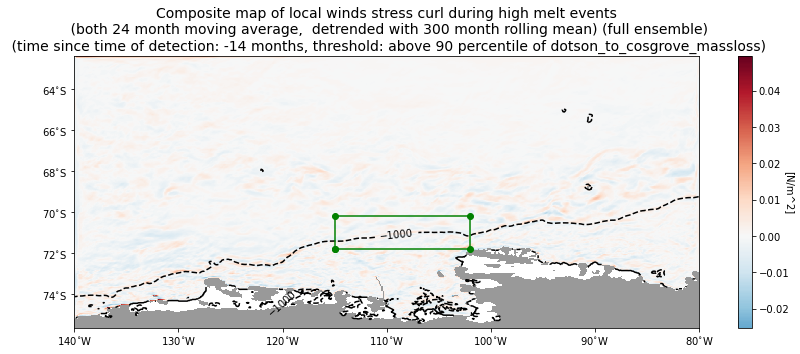

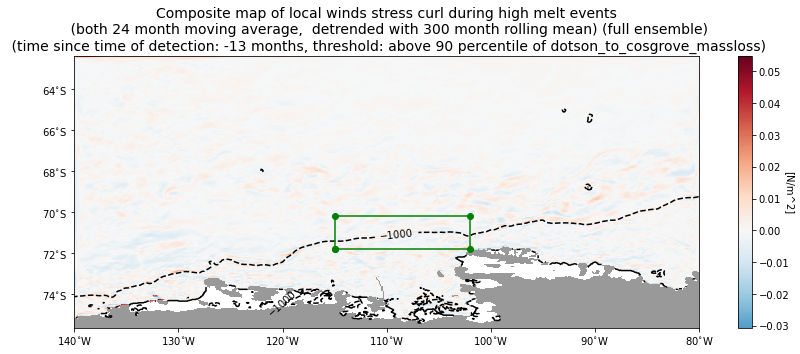

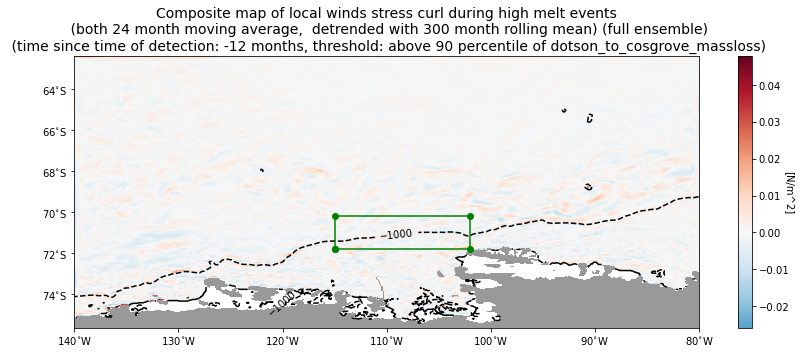

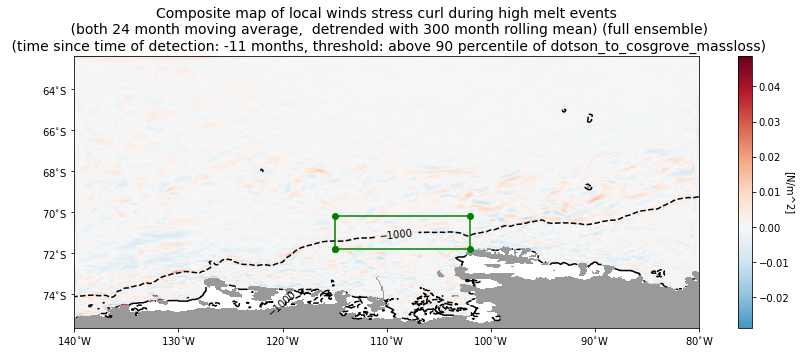

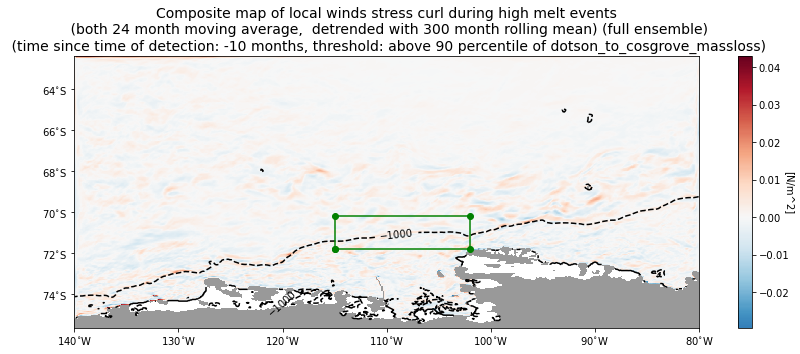

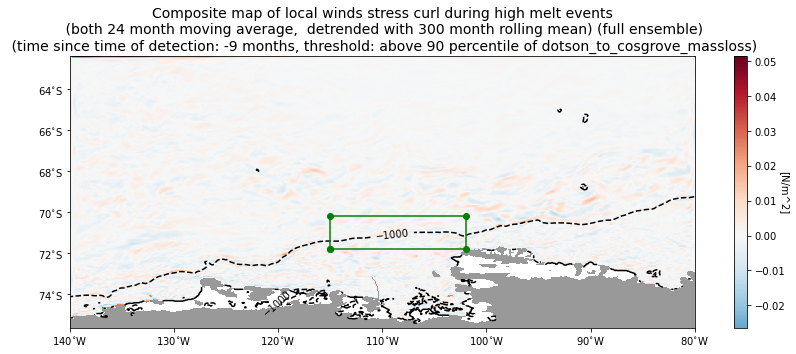

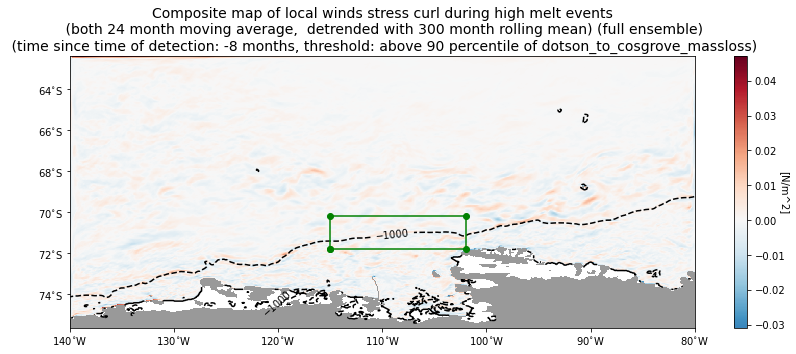

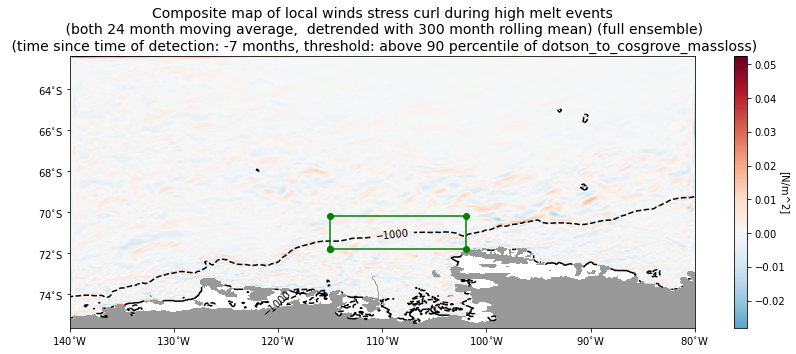

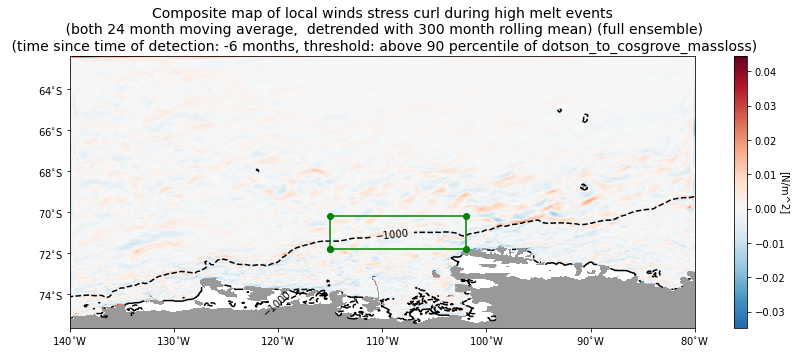

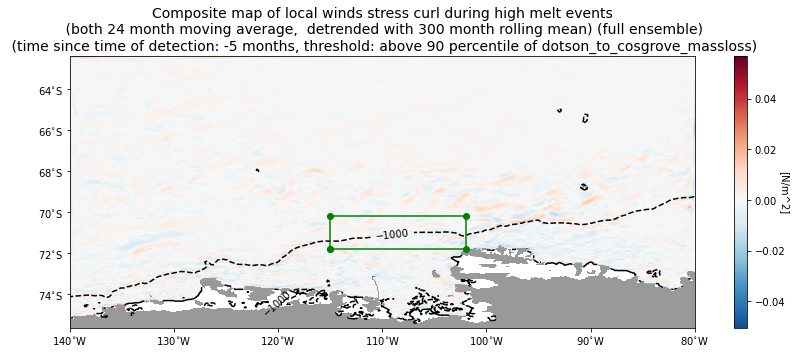

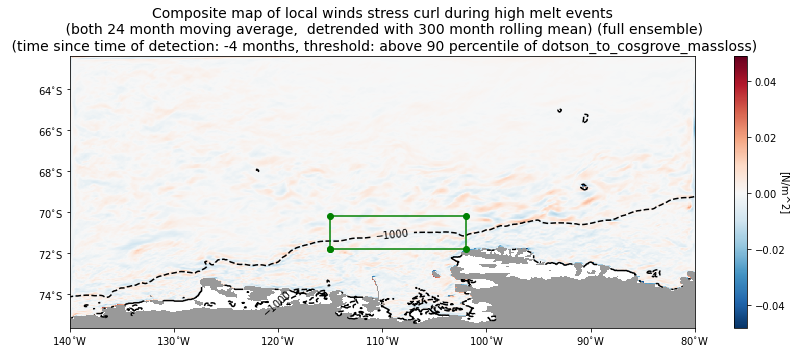

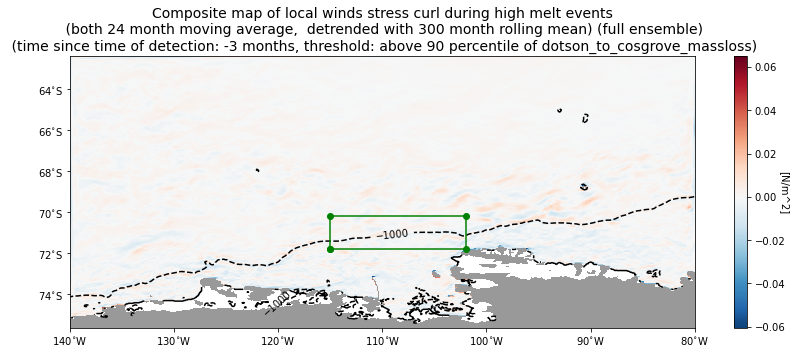

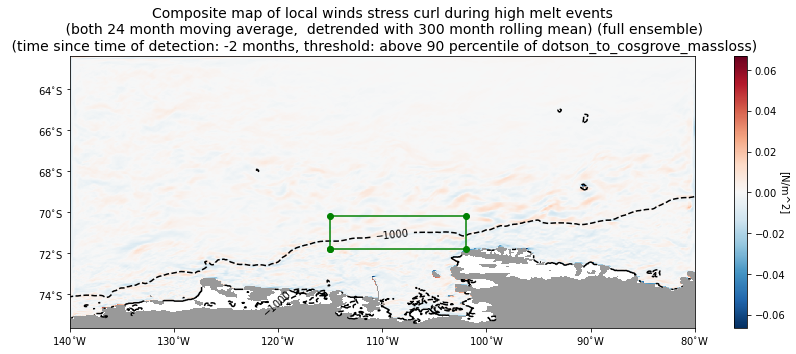

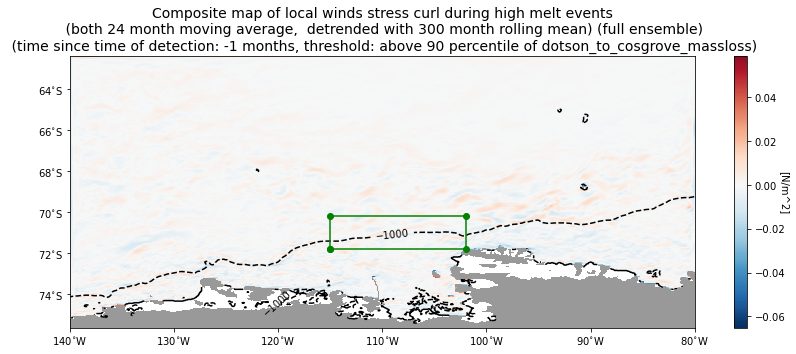

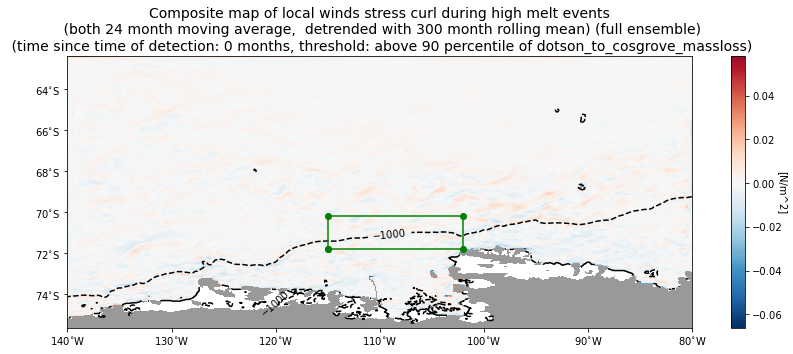

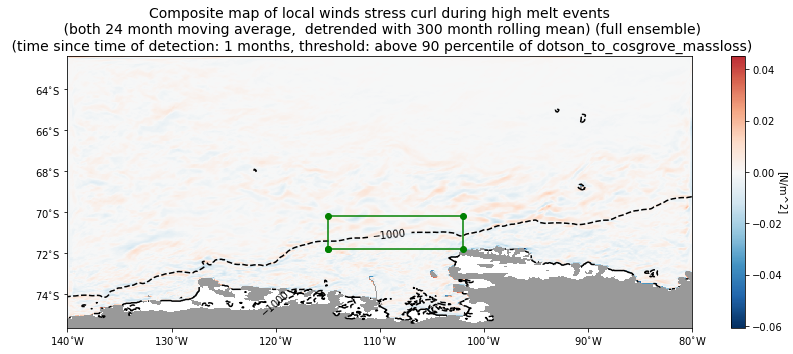

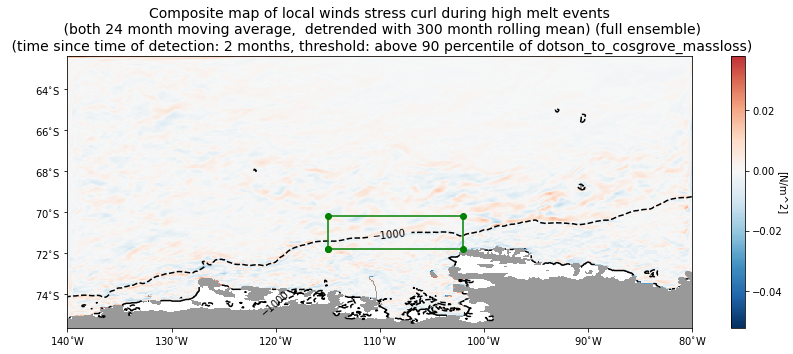

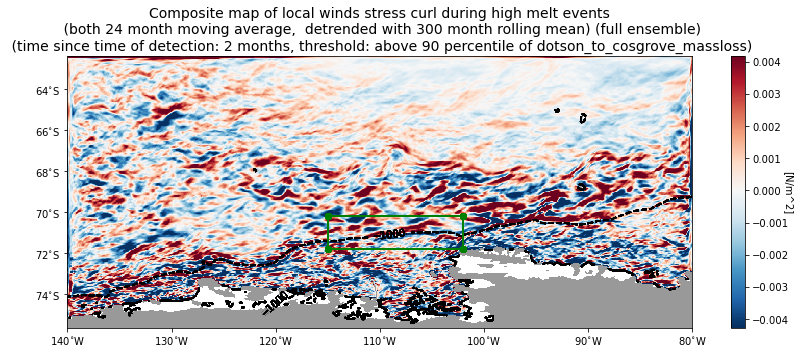

In [76]:
createCompositeMap(data_dt, title='Composite map of local winds stress curl during high melt events', 
                   filename='24monthmean_curlTAU',
                   unit='[N/m^2]',
                   window=window)

In [ ]:
# window=1 #Problem, this still should have the seasonal cycle....
# data_dt=detrend_and_average_MITgcmData(data, var, window=window)
# createCompositeMap(data_dt, title='Composite map of local zonal winds during high melt events', 
#                    filename='1monthmean_zonal_winds',
#                    tmvar='amundsen_shelf_break_uwind_avg',
#                    window=window)

In [ ]:
# tm=readMITgcmTimeSeries(var=tmvar, members=members)

# window=24
# data_dt=detrend_and_average_MITgcmData(data, var, window=window)
# tm_dt=detrend_and_average_MITgcmData(tm, tmvar, window=window)

# tsvar='amundsen_shelf_temp_btw_200_700m'
# ts=readMITgcmTimeSeries(var=tsvar, members=members)
# ts=detrend_and_average_MITgcmData(ts, tsvar, window=window)
# createCorrelationMap(data=data_dt, ts=ts, tm=tm_dt, 
#                     title='Correlation map of local zonal shelf wind with averaged Amundsen sea temperature (200-700m)', 
#                          filename='correlation_map_zonalwind_amundstemp', members=members, window=window)


In [ ]:
# tsvar='dotson_to_cosgrove_massloss'
# ts=readMITgcmTimeSeries(var=tsvar, members=members)
# ts=detrend_and_average_MITgcmData(ts, tsvar, window=window)
# createCorrelationMap(data=data_dt, ts=ts, tm=tm_dt, 
#                      title='Correlation map of local zonal shelf wind with Dotson to Cosgrove massloss', 
#                          filename='correlation_map_zonalwind_dot2cosmassloss', members=members, window=window)

In [ ]:
# window=60
# data_dt=detrend_and_average_MITgcmData(data, var, window=window)
# tm_dt=detrend_and_average_MITgcmData(tm, tmvar, window=window)

# tsvar='amundsen_shelf_temp_btw_200_700m'
# ts=readMITgcmTimeSeries(var=tsvar, members=members)
# ts=detrend_and_average_MITgcmData(ts, tsvar, window=window)
# createCorrelationMap(data=data_dt, ts=ts, tm=tm_dt, 
#                      title='Correlation map of local zonal shelf wind with averaged Amundsen sea temperature (200-700m)', 
#                          filename='correlation_map_zonalwind_amundstemp_60month_rm', members=members, window=window)

In [ ]:
# window=24
# data_dt=detrend_and_average_MITgcmData(data, var, window=window)
# tm_dt=detrend_and_average_MITgcmData(tm, tmvar, window=window)

# data_dt=data_dt.cumsum(dim='time')
# tm_dt=tm_dt.cumsum(dim='time')

# tsvar='dotson_to_cosgrove_massloss'
# ts=readMITgcmTimeSeries(var=tsvar, members=members)
# ts=detrend_and_average_MITgcmData(ts, tsvar, window=window)
# createCorrelationMap(data=data_dt, ts=ts, tm=tm_dt, 
#                      title='Correlation map of cumulative local zonal shelf wind with Dotson to Cosgrove massloss', 
#                          filename='correlation_map_cumul_zonalwind_dot2cosmassloss', members=members, window=window)


# tsvar='amundsen_shelf_temp_btw_200_700m'
# ts=readMITgcmTimeSeries(var=tsvar, members=members)
# ts=detrend_and_average_MITgcmData(ts, tsvar, window=window)
# createCorrelationMap(data=data_dt, ts=ts, tm=tm_dt, 
#                      title='Correlation map of cumulative local zonal shelf wind with averaged Amundsen sea temperature (200-700m)', 
#                          filename='correlation_map_cumul_zonalwind_amundstemp', members=members, window=window)



Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
Hello world!
